# Diversity of Ideas: Brown Daily Herald


## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import pandas as pd
from util.ouraws import (
    getFromFile
)

In [3]:
%pwd

'c:\\Users\\theod\\OneDrive\\dev\\diversity-ideas\\notebooks\\2024'

In [4]:
df = getFromFile("../../data/brown-opinions.parquet", False)
df.shape


(4750, 6)

In [5]:
df.head(4)

,title,url,body,year,month,day
0,"Harb ’04: Twenty years ago, Brown University d...",https://www.browndailyherald.com/article/2024/...,"Harb ’04: Twenty years ago, Brown University d...",2024,5,26
1,McCarthy ’24: On Belonging,https://www.browndailyherald.com/article/2024/...,"McCarthy ’24: On Belonging\nTruth be told, I w...",2024,5,24
2,Vulakh ’24: Looking beyond the Van Wickle Gate...,https://www.browndailyherald.com/article/2024/...,Vulakh ’24: Looking beyond the Van Wickle Gate...,2024,5,24
3,Zucker ’24: We Are All Born Lacking,https://www.browndailyherald.com/article/2024/...,Zucker ’24: We Are All Born Lacking\nWe are al...,2024,5,24


## Function Definitions

In [6]:
import numpy as np
import re

In [7]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [12]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.

In [13]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

## Analysis

In [14]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [15]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [16]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [18]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [19]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [20]:
type(wv[0])

list

In [21]:
docmatrix = np.array(wv)

In [22]:
docmatrix.shape

(129, 1024)

In [23]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

0       2024
1       2024
2       2024
3       2024
4       2024
        ... 
4745    2024
4746    2024
4747    2024
4748    2024
4749    2024
Name: year, Length: 129, dtype: int64, 129, 0.0009769469801413648, 0.5136156352770495


In [24]:
pairwise

0.5136156352770495

In [25]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = get_batch_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2009, 273, 0.000976989165502258, 0.4861258004024159
2010, 425, 0.0009769804430385292, 0.47433208607211463
2011, 422, 0.00097696064221617, 0.49756258073395115
2012, 436, 0.000976839242091601, 0.494429563808954
2013, 399, 0.0009770333551518565, 0.5168621367083419
2014, 383, 0.000976929117040756, 0.510786492568851
2015, 345, 0.0009769458444892634, 0.49503434197467294
2016, 315, 0.0009768658805909293, 0.4811350221037456
2017, 298, 0.0009770731390384986, 0.5037744586577625
2018, 309, 0.0009770430068696697, 0.4966094626745323
2019, 278, 0.0009769918536997942, 0.49766326789771187
2020, 217, 0.0009769788573105996, 0.4843287698450701
2021, 185, 0.0009768330691658287, 0.5030590775266242
2022, 160, 0.0009769296913843535, 0.5187638927189483
2023, 161, 0.0009769356440621367, 0.520392618470295
2024, 129, 0.0009769447855392144, 0.5136625007900457


In [25]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.485936,273,0.000977,0.000594,0.000509,0.000594,56,0.205128
2010,0.474267,425,0.000977,0.000617,0.000520,0.000617,103,0.242353
2011,0.497559,422,0.000977,0.000591,0.000497,0.000591,211,0.500000
2012,0.494330,436,0.000977,0.000601,0.000500,0.000601,189,0.433486
2013,0.516862,399,0.000977,0.000580,0.000480,0.000580,172,0.431078
2014,0.510815,383,0.000977,0.000586,0.000484,0.000586,235,0.613577
2015,0.495051,345,0.000977,0.000586,0.000500,0.000586,216,0.626087
2016,0.481148,315,0.000977,0.000606,0.000512,0.000606,263,0.834921
2017,0.503754,298,0.000977,0.000580,0.000491,0.000580,310,1.040268


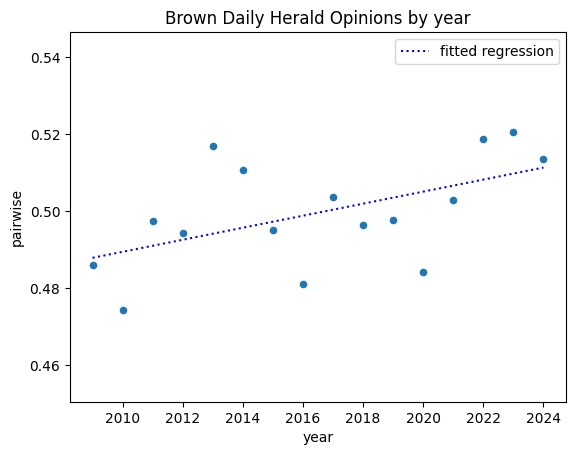

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Brown Daily Herald Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.04063, int:0.36235, r:0.75845, p:0.00066, se:0.00933, x:range(0, 16)
pairwise slope:0.00156, int:0.48793, r:0.53261, p:0.03367, se:0.00066, x:range(0, 16)


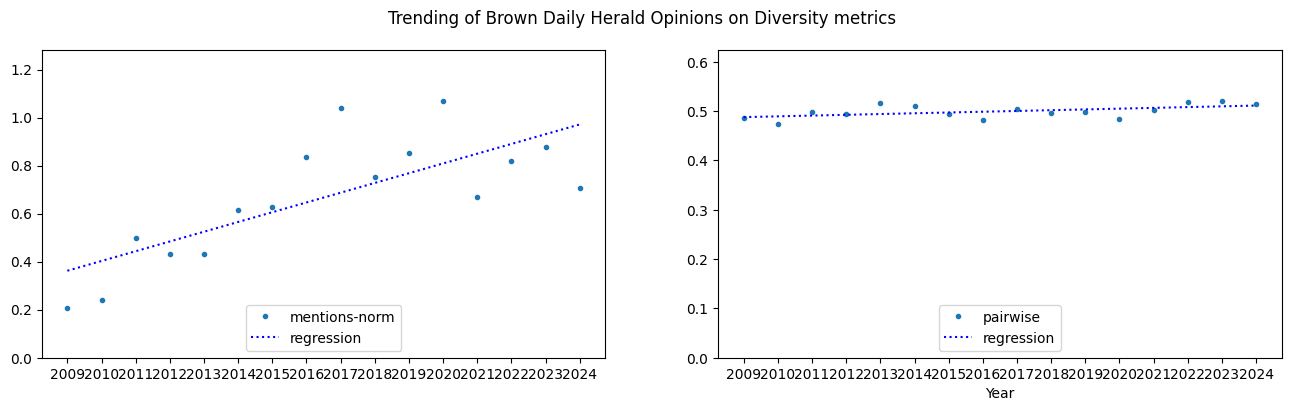

In [30]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Brown Daily Herald Opinions on Diversity metrics")
plt.show()